In [1]:
### Libraries

import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, classification_report, roc_auc_score, accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from pprint import pprint
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

In [2]:
### Load the data as tab separated values

ihds = pd.read_csv("36151-0002-Data.tsv",\
                   delimiter='\t', low_memory=False, header=0)

In [3]:
### Inspect shape

ihds.shape

(42152, 758)

In [4]:
### Subsetting to the variables under consideration

ihds_select = ihds[['URBAN2011',\
                    'CG7', 'CG8','CG10','CG13', \
                    'CG15','CG17', 'CG18', 'CG19', 'CG20', 'CG21','CG23',\
                    'CGCOMPUTER','SA1', 'SA2','WATER', 'SA4','FU1','HQWALL', \
                    'HQROOF', 'HQFLOOR', 'INCOME']].dropna().copy()

In [5]:
### Drop missing values and convert values to int

ihds_select = ihds_select.replace('-', np.nan)

def convert_to_int(x):
    try:
        return int(x)
    except ValueError:
        return np.nan

ihds_select = ihds_select.applymap(convert_to_int).dropna()

In [6]:
### Set bounds for the income to remove outliers and negative income

ihds_select = ihds_select[(ihds_select['INCOME'] >= 1000)]
ihds_select = ihds_select[(ihds_select['INCOME'] <= 1000000)]

In [7]:
### Inspect shape

ihds_select.shape

(40384, 22)

In [8]:
### Label households as eligible-ineligible
ihds_select['Category'] = np.where(ihds_select["INCOME"] <= 100000, 1, 0)

### Inspect distribution
ihds_select["Category"].value_counts()

1    25139
0    15245
Name: Category, dtype: int64

In [9]:
### Inspect distribution of select features

ihds_select[["CG10", "CG20", "CGCOMPUTER",  "CG17"]].apply(pd.Series.value_counts)

,CG10,CG20,CGCOMPUTER,CG17
0.0,15611,19218,37675,7852
1.0,24773,21166,2709,32532


In [10]:
### Convert categorical features to dummy values
ihds_select = pd.get_dummies(ihds_select, columns=['SA2', 'SA4']).dropna()

### Categorise house size to binary
ihds_select['room'] =  np.where(ihds_select["SA1"] >= 3, 1, 0)

In [11]:
### To plot characteristics

#ownership
df_means = ihds_select.groupby('Category')['CG7','CG8','CG10','CG13','CG15','CG17','CG18','CG19','CG20','CG21','CG23','CGCOMPUTER'].mean().reset_index()

#dwelling
df_house = ihds_select.groupby('Category')['FU1','HQFLOOR','HQROOF','HQWALL','room','SA2_1.0','SA2_2.0','SA2_3.0','SA4_1.0','SA4_2.0','SA4_3.0','SA4_4.0','WATER'].mean().reset_index()

C:\Users\connect4C\AppData\Local\Temp\ipykernel_17864\1610848056.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_means = ihds_select.groupby('Category')['CG7','CG8','CG10','CG13','CG15','CG17','CG18','CG19','CG20','CG21','CG23','CGCOMPUTER'].mean().reset_index()
C:\Users\connect4C\AppData\Local\Temp\ipykernel_17864\1610848056.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_house = ihds_select.groupby('Category')['FU1','HQFLOOR','HQROOF','HQWALL','room','SA2_1.0','SA2_2.0','SA2_3.0','SA4_1.0','SA4_2.0','SA4_3.0','SA4_4.0','WATER'].mean().reset_index()


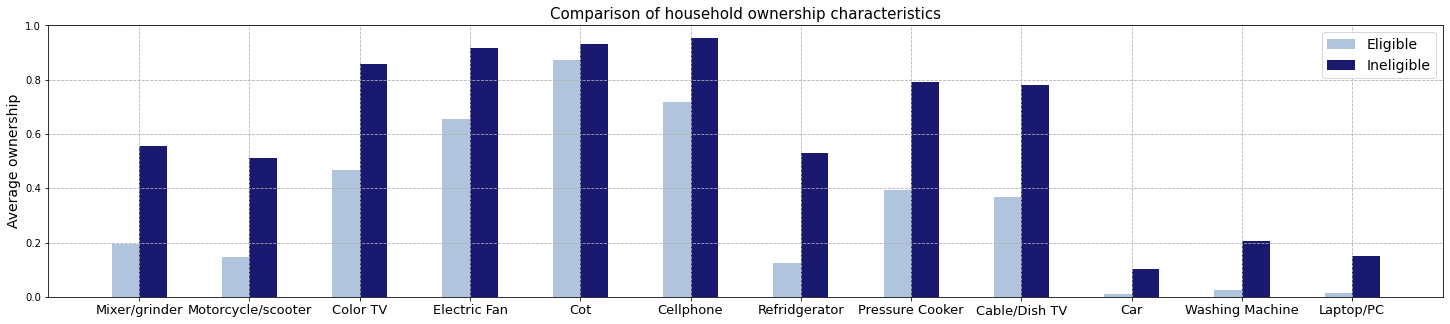

In [12]:
Eligible = df_means.drop(columns=['Category']).loc[1].values.tolist()
Ineligible = df_means.drop(columns=['Category']).loc[0].values.tolist()

n=12
r = np.arange(n)
width = 0.25
fig, ax = plt.subplots(figsize=(25, 5))  
  
plt.bar(r, Eligible, color = 'lightsteelblue',
        width = width, 
        label='Eligible')
plt.bar(r + width, Ineligible, color = 'midnightblue',
        width = width, 
        label='Ineligible')
  
#plt.xlabel("Household Ownership")
plt.ylabel("Average ownership", fontsize = 14)
plt.title("Comparison of household ownership characteristics", fontsize=15)
  
plt.grid(linestyle='--')
plt.xticks(r + width/2,['Mixer/grinder','Motorcycle/scooter','Color TV','Electric Fan','Cot','Cellphone','Refridgerator','Pressure Cooker','Cable/Dish TV','Car','Washing Machine','Laptop/PC'], fontsize=13)
plt.legend(fontsize=14)
#plt.savefig("D:/connect4c-Downloads/GU/DS2Project/ownership_0509.jpg", dpi=300)
plt.show()

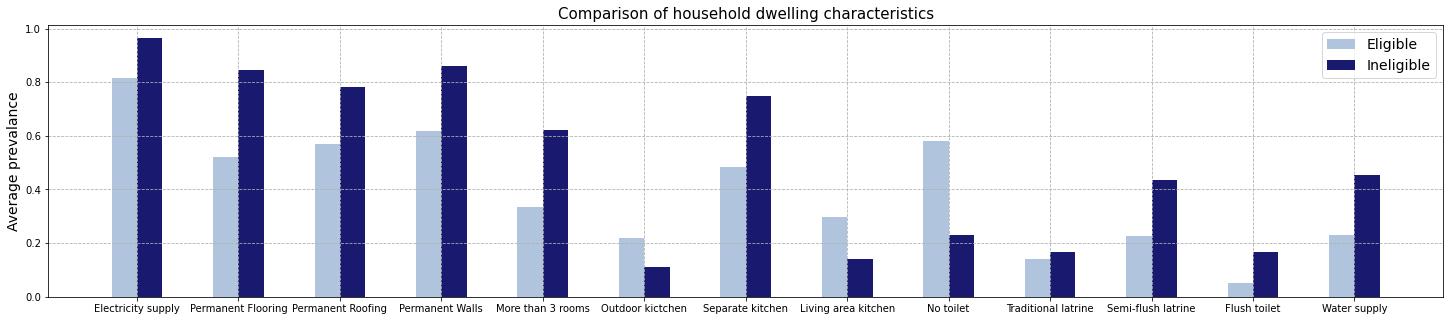

In [13]:
E2 = df_house.drop(columns=['Category']).loc[1].values.tolist()
I2 = df_house.drop(columns=['Category']).loc[0].values.tolist()


n=13
r = np.arange(n)
width = 0.25
fig, ax = plt.subplots(figsize=(25, 5))  
  
plt.bar(r, E2, color = 'lightsteelblue',
        width = width, 
        label='Eligible')
plt.bar(r + width, I2, color = 'midnightblue',
        width = width, 
        label='Ineligible')
  
plt.ylabel("Average prevalance",fontsize=14)
plt.title("Comparison of household dwelling characteristics", fontsize=15)
  
plt.grid(linestyle='--')
plt.xticks(r + width/2,['Electricity supply','Permanent Flooring','Permanent Roofing','Permanent Walls','More than 3 rooms','Outdoor kictchen','Separate kitchen','Living area kitchen','No toilet','Traditional latrine','Semi-flush latrine','Flush toilet', 'Water supply'])
plt.legend(fontsize=14)
#plt.savefig("D:/connect4c-Downloads/GU/DS2Project/dwelling.jpg", dpi=300)
plt.show()

In [14]:
### Setting the feature matrix
X = ihds_select.drop(['INCOME', 'Category', 'SA1'], axis=1)
X.shape

(40384, 26)

In [15]:
### Setting the target matrix
y = ihds_select.Category
y.shape

(40384,)

In [16]:
### train-test split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=37)

In [17]:
### Model 1.1a - Logisitic reg on original dataset

logreg = LogisticRegression()
logreg.fit(Xtrain, ytrain)
print('Accuracy:', logreg.score(Xtest, ytest))
confusion_matrix(ytest, logreg.predict(Xtest))
print(classification_report(ytest, logreg.predict(Xtest)))

Accuracy: 0.7648563882469462
              precision    recall  f1-score   support

           0       0.72      0.61      0.66      4521
           1       0.79      0.86      0.82      7595

    accuracy                           0.76     12116
   macro avg       0.75      0.73      0.74     12116
weighted avg       0.76      0.76      0.76     12116



In [18]:
### Model 1.1a -top 10 features of the logisitic model


coefs = logreg.coef_[0]
abs_coefs = [abs(c) for c in coefs]

sorted_idx = sorted(range(len(abs_coefs)), key=lambda i: abs_coefs[i], reverse=True)

for i in range(10):
    idx = sorted_idx[i]
    print(f"{Xtrain.columns[idx]} ({coefs[idx]:.4f})")

CG17 (-0.8424)
CG8 (-0.6588)
CGCOMPUTER (-0.6349)
CG18 (-0.5935)
CG21 (-0.5099)
room (-0.4518)
CG19 (-0.3143)
CG20 (-0.2965)
CG10 (-0.2896)
SA4_1.0 (0.2566)


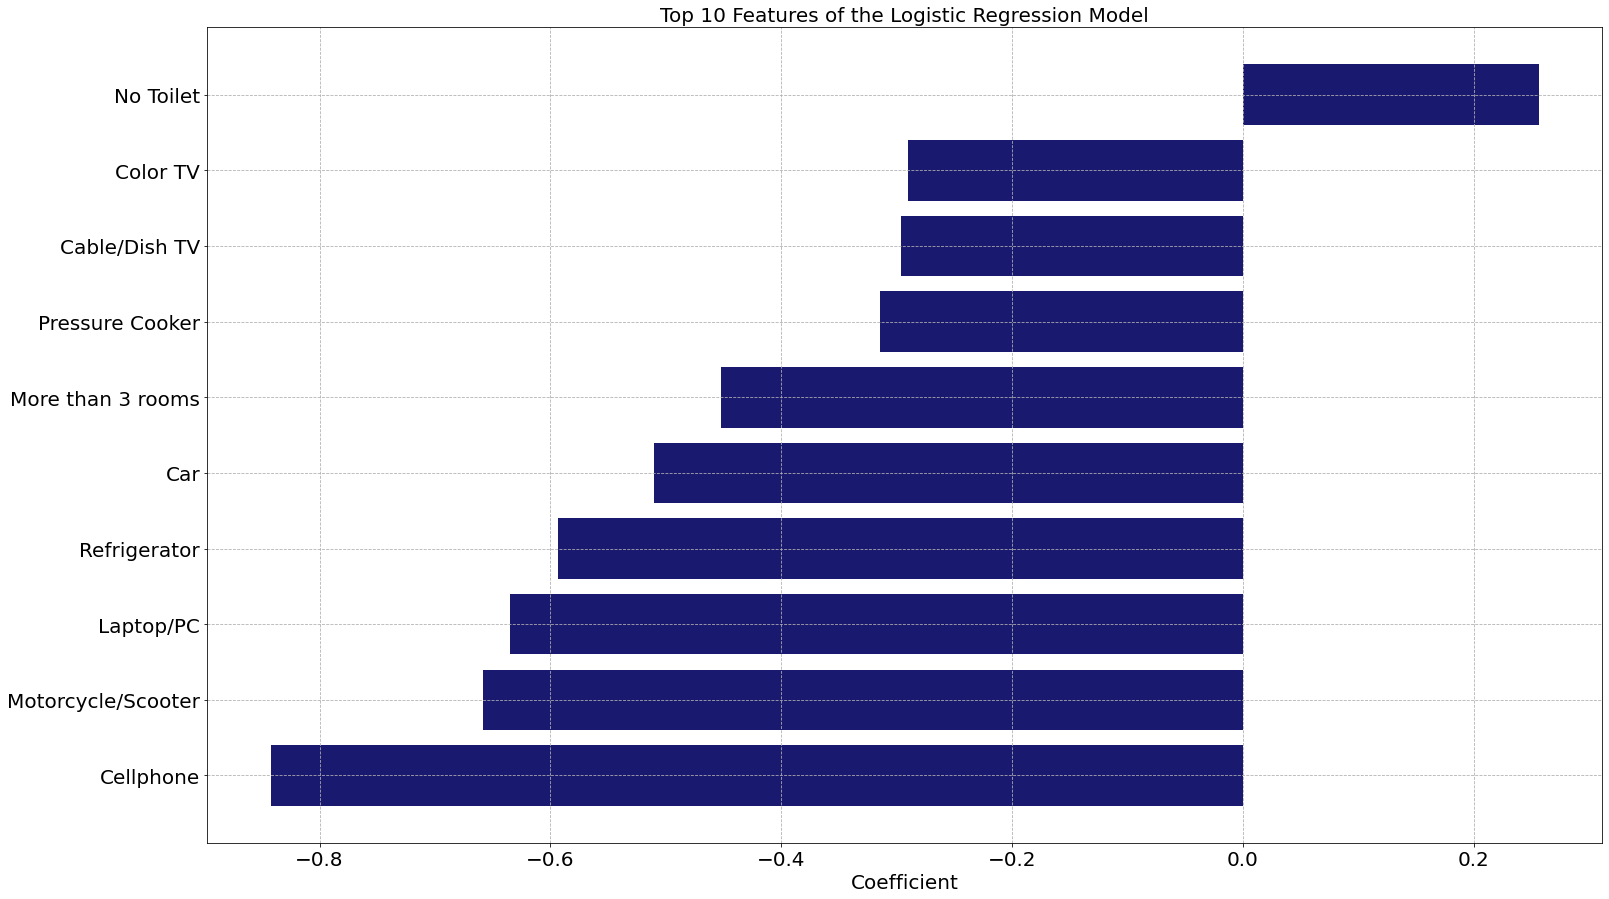

In [19]:
top_features = []
top_coefs = []
for i in range(10):
    idx = sorted_idx[i]
    top_features.append(Xtrain.columns[idx])
    top_coefs.append(coefs[idx])


n=10
r = np.arange(n)    
plt.figure(figsize=(25, 15))
plt.barh(top_features, top_coefs, color='midnightblue')
plt.grid(linestyle='--')
plt.yticks(r, ['Cellphone', 'Motorcycle/Scooter', 'Laptop/PC', 'Refrigerator', 'Car', 'More than 3 rooms', 'Pressure Cooker', 'Cable/Dish TV', 'Color TV', 'No Toilet'], fontsize = 20)
plt.xticks(fontsize=20)
plt.xlabel('Coefficient', fontsize = 20)
plt.title('Top 10 Features of the Logistic Regression Model', fontsize = 20)
#plt.savefig("D:/connect4c-Downloads/GU/DS2Project/top10.jpg", dpi=300)
plt.show()

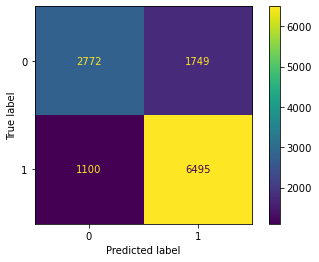

In [20]:
### Model 1.1a -confusion matrix of the logit model

logreg_cm = confusion_matrix(ytest, logreg.predict(Xtest))
logreg_disp = ConfusionMatrixDisplay(confusion_matrix=logreg_cm)
logreg_disp.plot()

In [21]:
### Model 2.1 - LDA

lda = LinearDiscriminantAnalysis()
lda.fit(Xtrain, ytrain)
print('Accuracy:', lda.score(Xtest, ytest))
confusion_matrix(ytest, lda.predict(Xtest))
print(classification_report(ytest, lda.predict(Xtest)))

Accuracy: 0.7641135688345989
              precision    recall  f1-score   support

           0       0.72      0.61      0.66      4521
           1       0.79      0.86      0.82      7595

    accuracy                           0.76     12116
   macro avg       0.75      0.73      0.74     12116
weighted avg       0.76      0.76      0.76     12116



In [22]:
### Model 3.1 - KNN

knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(Xtrain, ytrain)
print('Accuracy:', knn.score(Xtest, ytest))
confusion_matrix(ytest, knn.predict(Xtest))
print(classification_report(ytest, knn.predict(Xtest)))

Accuracy: 0.7411687025420931
              precision    recall  f1-score   support

           0       0.65      0.67      0.66      4521
           1       0.80      0.78      0.79      7595

    accuracy                           0.74     12116
   macro avg       0.72      0.73      0.73     12116
weighted avg       0.74      0.74      0.74     12116



In [23]:
### Model 4.1 - Random Forest

rf = RandomForestClassifier(n_estimators=150, random_state=37, min_samples_leaf= 4, max_features = 'auto')
rf.fit(Xtrain, ytrain)
print('Accuracy:', rf.score(Xtest, ytest))
confusion_matrix(ytest, rf.predict(Xtest))
print(classification_report(ytest, rf.predict(Xtest)))

Accuracy: 0.7658468141300759
              precision    recall  f1-score   support

           0       0.72      0.62      0.66      4521
           1       0.79      0.85      0.82      7595

    accuracy                           0.77     12116
   macro avg       0.75      0.74      0.74     12116
weighted avg       0.76      0.77      0.76     12116



In [24]:
### Model 5.1 - SVC

svc = SVC(kernel = 'rbf', C = 1, probability=True)
svc.fit(Xtrain, ytrain)
print('Accuracy:', svc.score(Xtest, ytest))
confusion_matrix(ytest, svc.predict(Xtest))
print(classification_report(ytest, svc.predict(Xtest)))

Accuracy: 0.7621327170683394
              precision    recall  f1-score   support

           0       0.71      0.61      0.66      4521
           1       0.79      0.85      0.82      7595

    accuracy                           0.76     12116
   macro avg       0.75      0.73      0.74     12116
weighted avg       0.76      0.76      0.76     12116



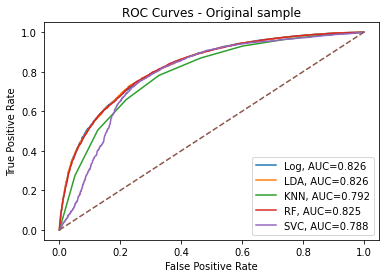

In [25]:
### plotting roc-auc for all the models

fpr, tpr, _ = metrics.roc_curve(ytest, logreg.predict_proba(Xtest)[:,1])
auc = round(metrics.roc_auc_score(ytest, logreg.predict_proba(Xtest)[:,1]), 3)
plt.plot(fpr,tpr,label="Log, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(ytest, lda.predict_proba(Xtest)[:,1])
auc = round(metrics.roc_auc_score(ytest, lda.predict_proba(Xtest)[:,1]), 3)
plt.plot(fpr,tpr,label="LDA, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(ytest, knn.predict_proba(Xtest)[:,1])
auc = round(metrics.roc_auc_score(ytest, knn.predict_proba(Xtest)[:,1]), 3)
plt.plot(fpr,tpr,label="KNN, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(ytest, rf.predict_proba(Xtest)[:,1])
auc = round(metrics.roc_auc_score(ytest, rf.predict_proba(Xtest)[:,1]), 3)
plt.plot(fpr,tpr,label="RF, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(ytest, svc.predict_proba(Xtest)[:,1])
auc = round(metrics.roc_auc_score(ytest, svc.predict_proba(Xtest)[:,1]), 3)
plt.plot(fpr,tpr,label="SVC, AUC="+str(auc))

ns_probs = [0 for _ in range(len(ytest))]
ns_auc = roc_auc_score(ytest, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(ytest, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--')


plt.title('ROC Curves - Original sample')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
#plt.savefig("D:/connect4c-Downloads/GU/DS2Project/stg-1_0509.jpg", dpi=300)
plt.show()

In [26]:
### training models on the SMOTE samples
### applying SMOTE sampling
sm = SMOTE(sampling_strategy='minority', random_state=37)
Xres, yres = sm.fit_resample(X, y)

In [27]:
### train-test split

Xsmtrain, Xsmtest, ysmtrain, ysmtest = train_test_split(Xres, yres, test_size=0.3, random_state=37)

In [28]:
### Model 1.2a 

logitsm = LogisticRegression()
logitsm.fit(Xsmtrain, ysmtrain)
print('Accuracy:', logitsm.score(Xsmtest, ysmtest))
confusion_matrix(ysmtest, logitsm.predict(Xsmtest))
print(classification_report(ysmtest, logitsm.predict(Xsmtest)))

Accuracy: 0.7505303632988597
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      7609
           1       0.75      0.75      0.75      7475

    accuracy                           0.75     15084
   macro avg       0.75      0.75      0.75     15084
weighted avg       0.75      0.75      0.75     15084



In [29]:
### Model 2.2

ldasm = LinearDiscriminantAnalysis()
ldasm.fit(Xsmtrain, ysmtrain)
print('Accuracy:', ldasm.score(Xsmtest, ysmtest))
confusion_matrix(ysmtest, lda.predict(Xsmtest))
print(classification_report(ysmtest, lda.predict(Xsmtest)))

Accuracy: 0.7511270220100769
              precision    recall  f1-score   support

           0       0.81      0.62      0.70      7609
           1       0.69      0.86      0.76      7475

    accuracy                           0.74     15084
   macro avg       0.75      0.74      0.73     15084
weighted avg       0.75      0.74      0.73     15084



In [30]:
### Model 3.2

knnsm = KNeighborsClassifier(n_neighbors=8)
knnsm.fit(Xsmtrain, ysmtrain)
print('Accuracy:', knnsm.score(Xsmtest, ysmtest))
confusion_matrix(ysmtest, knnsm.predict(Xsmtest))
print(classification_report(ysmtest, knnsm.predict(Xsmtest)))

Accuracy: 0.7483426146910633
              precision    recall  f1-score   support

           0       0.72      0.81      0.76      7609
           1       0.78      0.69      0.73      7475

    accuracy                           0.75     15084
   macro avg       0.75      0.75      0.75     15084
weighted avg       0.75      0.75      0.75     15084



In [31]:
### Model 4.2

rfsm = RandomForestClassifier(n_estimators=120, random_state=37, max_features=None)
rfsm.fit(Xsmtrain, ysmtrain)
print('Accuracy:', rfsm.score(Xsmtest, ysmtest))
confusion_matrix(ysmtest, rfsm.predict(Xsmtest))
print(classification_report(ysmtest, rfsm.predict(Xsmtest)))

Accuracy: 0.7690930787589498
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      7609
           1       0.77      0.77      0.77      7475

    accuracy                           0.77     15084
   macro avg       0.77      0.77      0.77     15084
weighted avg       0.77      0.77      0.77     15084



In [32]:
### Model 5.2

svcsm = SVC(kernel = 'rbf', C = 1, probability=True)
svcsm.fit(Xsmtrain, ysmtrain)
print('Accuracy:', svcsm.score(Xsmtest, ysmtest))
confusion_matrix(ysmtest, svcsm.predict(Xsmtest))
print(classification_report(ysmtest, svcsm.predict(Xsmtest)))

Accuracy: 0.7639220365950676
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      7609
           1       0.76      0.76      0.76      7475

    accuracy                           0.76     15084
   macro avg       0.76      0.76      0.76     15084
weighted avg       0.76      0.76      0.76     15084



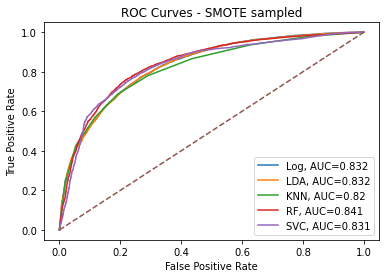

In [33]:
### plotting roc-auc curves for smote sampled

fpr, tpr, _ = metrics.roc_curve(ysmtest, logitsm.predict_proba(Xsmtest)[:,1])
auc = round(metrics.roc_auc_score(ysmtest, logitsm.predict_proba(Xsmtest)[:,1]), 3)
plt.plot(fpr,tpr,label="Log, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(ysmtest, ldasm.predict_proba(Xsmtest)[:,1])
auc = round(metrics.roc_auc_score(ysmtest, ldasm.predict_proba(Xsmtest)[:,1]), 3)
plt.plot(fpr,tpr,label="LDA, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(ysmtest, knnsm.predict_proba(Xsmtest)[:,1])
auc = round(metrics.roc_auc_score(ysmtest, knnsm.predict_proba(Xsmtest)[:,1]), 3)
plt.plot(fpr,tpr,label="KNN, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(ysmtest, rfsm.predict_proba(Xsmtest)[:,1])
auc = round(metrics.roc_auc_score(ysmtest, rfsm.predict_proba(Xsmtest)[:,1]), 3)
plt.plot(fpr,tpr,label="RF, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(ysmtest, svcsm.predict_proba(Xsmtest)[:,1])
auc = round(metrics.roc_auc_score(ysmtest, svcsm.predict_proba(Xsmtest)[:,1]), 3)
plt.plot(fpr,tpr,label="SVC, AUC="+str(auc))

ns_probs = [0 for _ in range(len(ysmtest))]
ns_auc = roc_auc_score(ysmtest, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(ysmtest, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--')

plt.title('ROC Curves - SMOTE sampled')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
#plt.savefig("D:/connect4c-Downloads/GU/DS2Project/stg3_0509.jpg", dpi=300)
plt.show()

In [34]:
### comparison between full feature model and top 10 feature model ###
### subsetting to top 10 features of logistic regression

ihds_10 = ihds_select[['CG17', 'CG8','CGCOMPUTER','CG18','CG21', 'room', 'CG19', 'CG20', 'CG10', 'SA4_1.0', 'Category']].dropna().copy()

In [35]:
### assigning feature matrix and target

Xn = ihds_10.drop(['Category'], axis=1)
yn = ihds_10.Category

In [36]:
### train-test split

Xntrain, Xntest, yntrain, yntest = train_test_split(Xn, yn, test_size=0.3, random_state=37)

In [37]:
### Model 1.1B - logreg on top 10

logit10 = LogisticRegression()
logit10.fit(Xntrain, yntrain)
print('Accuracy:', logit10.score(Xntest, yntest))
confusion_matrix(yntest, logit10.predict(Xntest))
print(classification_report(yntest, logit10.predict(Xntest)))

Accuracy: 0.7613898976559921
              precision    recall  f1-score   support

           0       0.72      0.59      0.65      4521
           1       0.78      0.86      0.82      7595

    accuracy                           0.76     12116
   macro avg       0.75      0.73      0.73     12116
weighted avg       0.76      0.76      0.76     12116



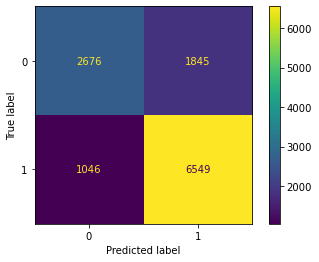

In [38]:
### confusion matrix
logit_cm = confusion_matrix(yntest, logit10.predict(Xntest))
logit_disp = ConfusionMatrixDisplay(confusion_matrix=logit_cm)
logit_disp.plot()